# k-nearest neighbors (kNN)

## Chronic Kidney Disease
We are interested in predicting whether patients will develop Chronic Kidney Disease (CKD). We have historical data for a set of patients in terms of their attributes (their $X$s, which are mostly blood related) and in terms of their binary outcomes (their $Y$)---they either developed CKD ($Y=1$) or they did not ($Y=0$).

We do not the *exact* relationship between the $X$s and the $Y$s, and we will use (basic) machine learning to explore it.  The goal is to allow us to look at a "new" patient -- in terms of their $X$ variables -- and make a good prediction as to whether they will develop CKD or not.

## The CKD Data

Let us load the data and take a look. One of visualizations below will use the `patches` functions in `matplotlib`, so we will `import` them here.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import pandas as pd
import numpy as np

ckd = pd.read_csv('data/ckd.csv')

You can look at the data directly via e.g. `ckd.head()`. But this is quite wide.  Clearly we have many variables available to us:

In [2]:
ckd.columns.tolist()

['Age',
 'Blood Pressure',
 'Specific Gravity',
 'Albumin',
 'Sugar',
 'Red Blood Cells',
 'Pus Cell',
 'Pus Cell clumps',
 'Bacteria',
 'Blood Glucose Random',
 'Blood Urea',
 'Serum Creatinine',
 'Sodium',
 'Potassium',
 'Hemoglobin',
 'Packed Cell Volume',
 'White Blood Cell Count',
 'Red Blood Cell Count',
 'Hypertension',
 'Diabetes Mellitus',
 'Coronary Artery Disease',
 'Appetite',
 'Pedal Edema',
 'Anemia',
 'Class']

The final one here is `Class` taking the value `1` if the patient had CKD and `0` otherwise.  We will be making use of a few of the variables, including `Blood Glucose Random`.  This is annoying to type out every time, so we will just rename it (in place) as `Glucose`.

In [3]:
ckd = ckd.rename(columns={'Blood Glucose Random': 'Glucose'})

The other variables of interest to us are `Hemoglobin` and `White Blood Cell Count`. 

### Standardization

Before we start building a classifier, note that it is typical in machine learning problems like the one we are about tackle to *standardize* our variables prior to using them for prediction.  The basic reason for this is to avoid the scale on which a variable is measured affecting its importance in classification. To understand this point, note that our technique below will ask how "far" one observation is from another. If we don't standardize the variables, the ones that happen to have averages that are bigger (raw) numbers (e.g. the patient's height in inches) will overwhelm those measured with smaller (raw) numbers (e.g. the patient's number of previous surgeries).  Yet presumably it is patients *relative* positions on these things that are most useful for predicting outcomes.  

Of course, we have met a standardizing function before:

In [4]:
def standard_units(x):
    return (x - np.mean(x))/np.std(x)

And we will just, for now, apply it to a small number of variables, before converting everything back to a `pandas` object:

In [5]:
mydata = ([ckd[['Class']], 
        standard_units(ckd[['Hemoglobin']]),  
        standard_units(ckd[['Glucose']]),
        standard_units(ckd[['White Blood Cell Count']])       
        ])

std_data = pd.concat(mydata, axis=1)

### Inspecting the data
To get the lay of the land, and a basic overview of the problem, let's plot the data. In particular, let's plot patients in two dimensions: `Hemoglobin` on the $x$-axis, `Glucose` on the $y$-axis and the color the points (the patients) by their CKD class.

First, we will rename the `Class` variable to be a more intuitive `status` variable:

In [6]:
std_status = std_data.copy(deep=True) 

std_status.loc[std_status['Class']== 1,'status'] = 'CKD'
std_status.loc[std_status['Class']== 0,'status'] = 'CKD free'

Next, we create a dictionary for the colors, and tell the `.scatter()` function to find the appropriate color for each `status` via `.map()`. We use the `matplotlib` `patches` functions just to put colored rectangles on the legend.

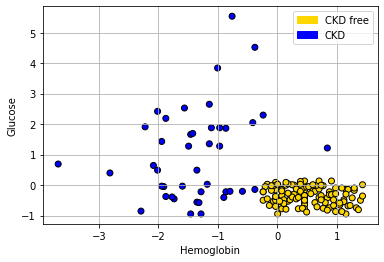

In [7]:
colors = {'CKD free':'gold', 'CKD':'blue'}

plt.scatter(std_status['Hemoglobin'], std_status['Glucose'], 
            color = std_status['status'].map(colors), 
           edgecolors="black")
plt.grid()

gold_patch = mpatches.Patch(color='gold', label='CKD free')
blue_patch = mpatches.Patch(color='blue', label='CKD')

plt.legend(handles=[gold_patch, blue_patch])
plt.xlabel("Hemoglobin")
plt.ylabel("Glucose")
plt.show()

Looking at the plot, it seems that those with "high" Hemoglobin and "low" Glucose are CKD free.  Meanwhile, other combinations of those variables seem to be associated with getting CKD.

## Nearest Neighbor classification

When a new patient arrives, we need a predicted class for her. What is a good way to do this?  A simple idea is to ask which current patients she is like, and see what happened to that current patient.  And then just use that class as the prediction for the new patient.  

More formally: 
1. look at the new patient's *attributes* (Hemoglobin, Glucose)
2. look up the current patient who has the *most similar* values on these attributes
3. whatever the CKD status of that current patient, assign the same status to the new patient.

We will give more specifics imminently, but this basic design is called **nearest neighbor classification**.

### Useful functions

Before we get into the theoretical details of how this might work, we will define a series of functions to help us do it in practice.  We will explain them in more detail below, but for now we first provide a brief description of each function followed by the actual functions.

- `distance` calculates the Euclidean distance between two points (these could be rows of data).
- `all_distances` calculates the distance between a row and all other rows in the data.
- `table_with_distances` returns the training data, but with a column showing the distance from each row of that data to some example we are interested in.
- `closest`  returns the top-k (so the k closest) rows to our data point of interest.
- `majority` does a majority vote among the top-k closest rows to give us a prediction; in this case, the prediction will be either zero or one.
- `classify` uses the function above to tell us the classification of a given example (an instance).

In [8]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [9]:
def all_distances(training, point):
    """The distance between p (an array of numbers) 
    and the numbers in row i of a table of attributes."""
    attributes = training.drop(columns = 'Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    some_distances = attributes.apply(distance_from_point, axis = 1) 
    return some_distances

In [10]:
def table_with_distances(training, point):
    """A copy of the training table with the
    distance from each row to array p."""
    train_set_copy = training.copy(deep=True) 
    ad = all_distances(train_set_copy, point)
    train_set_copy['Distance'] = ad
    return train_set_copy

In [11]:
def closest(training, point, k):
    """A table containing the k closest 
    rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort_values(by = ['Distance'] )
    topk = sorted_by_distance.take(np.arange(k))
    return topk

In [12]:
def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, and 0 otherwise."""
    ones =  topkclasses[topkclasses["Class"]  == 1]
    zeros = topkclasses[topkclasses["Class"] == 0]
    if len(ones) > len(zeros):
        return 1
    else:
        return 0  

In [13]:
def classify(training, p, k):
    """Classify an example with attributes p 
    using k-nearest neighbor classification with 
    the given training table."""
    topkclasses = closest(training, p, k)
    return majority(topkclasses)

### Plotting the new patient
The intuition here is straightforward.  Consider a new patient (in red) on our original plot above: her name is *Alice*, and her variable values are 0 for Hemoglobin and 1.5 for Glucose.  Thus:

In [14]:
alice = np.array([0, 1.5])

Let's put her on the plot:

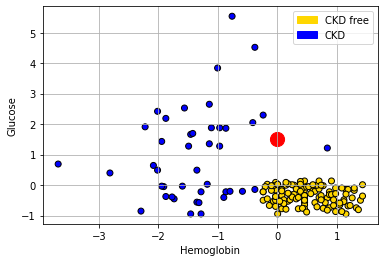

In [15]:
plt.scatter(std_status['Hemoglobin'], std_status['Glucose'], 
            color = std_status['status'].map(colors), 
           edgecolors="black")
plt.grid()

gold_patch = mpatches.Patch(color='gold', label='CKD free')
blue_patch = mpatches.Patch(color='blue', label='CKD')

plt.legend(handles=[gold_patch, blue_patch])
plt.xlabel("Hemoglobin")
plt.ylabel("Glucose")

plt.scatter(alice.item(0), alice.item(1), color='red', s=200)
plt.show()

She appears to be closest to the blue cluster of points, but we can make this more explicit by drawing a line between her and the nearest current point in the data. 

In [16]:
def show_closest(point):
    """point = array([x,y]) gives the coordinates 
    of a new point shown in red"""
    
    HemoGl = std_data.drop(['White Blood Cell Count'], axis=1)
    t = closest(HemoGl, point, 1)   
    x_closest = t.iloc[0,1] # get nearest point's x coord
    y_closest = t.iloc[0,2] # get nearest point's y coord
    
    plt.scatter(std_status['Hemoglobin'], std_status['Glucose'], 
                color = std_status['status'].map(colors), 
                edgecolors="black")
    
    plt.scatter(point.item(0), point.item(1), color='red', s=200)
    plt.grid()
    plt.plot(np.array([point.item(0), x_closest]), 
             np.array([point.item(1), y_closest]), 
             color='k', lw=2, linestyle='dotted')
    plt.xlabel("Hemoglobin")
    plt.ylabel("Glucose")
    plt.show()

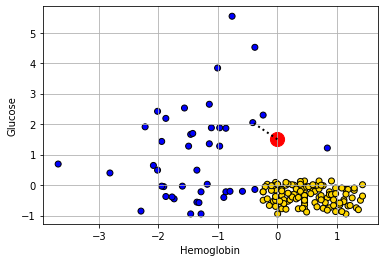

In [17]:
show_closest(alice)

Let's consider another patient, Bob:

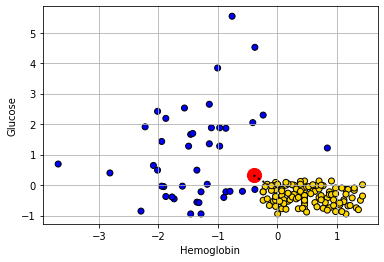

In [18]:
bob = np.array([-0.4, 0.32])
show_closest(bob)

His nearest neighbor has CKD, so that is our prediction for Bob. 

## Decision boundary

These examples demonstrate a simple point: given *any* combination of attributes, we can provide a prediction.  We just look up which current patient is closest to our new patient, and that's it.  If we did this for *every* point in the two dimensional space, we would obtain a **decision boundary**.  This is

> a line that separates the attribute space into two parts, where each part corresponds to our model predicting a given class as an outcome.

We will work in two dimensional attribute space for now, and we will have a two class problem, but the idea is more general than that.  For example, one can draw a *decision (hyper)plane* in three dimensions, and one can place instances in *multiple* classes.

One reason we draw this boundary is so we can see what regions of the space correspond to what predicted classes. This is immediately informative about how our classifier works in practice, and also about the underlying nature of the relationship between the attributes and outcomes. To see how this works, imagine filling the filling to space with *lots* of new patients---one for "every" combination of the features in small steps along the axes.

In [19]:
x_array = np.array([])
y_array = np.array([])
for x in np.arange(-2, 2.1, 0.1):
    for y in np.arange(-2, 2.1, 0.1):
        x_array = np.append(x_array, x)
        y_array = np.append(y_array, y)

grid_data = {
  "Hemoglobin": x_array,
  "Glucose": y_array
}
        
test_grid = pd.DataFrame(grid_data)

Here, `test_grid` is just a bunch of pretend or invented instances with various combinations of attributes.  We will slightly restrict the space of though attributes here (from `-2` to `2` on both variables), but that is just for visualization purposes.  Let's plot these pretend instances in red, and then put the "real" data on in its usual colors.

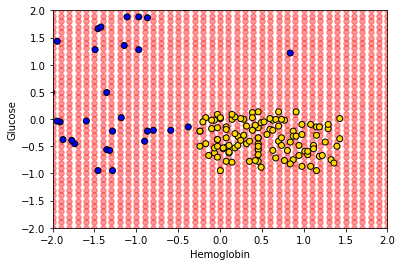

In [20]:
plt.scatter(test_grid['Hemoglobin'],
            test_grid['Glucose'], color='red', alpha=0.4, s=30)

plt.scatter(std_status['Hemoglobin'], std_status['Glucose'], 
            color = std_status['status'].map(colors), edgecolors="black")
plt.xlabel("Hemoglobin")
plt.ylabel("Glucose")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

To reiterate, every one of the red points has a nearest neighbor (which is either yellow or blue).  Let's find that nearest neighbor for every point. The function we need is this one:

In [21]:
def classify_grid(training, test, k):
    c = np.array([])
    for i in range(len(test)):
        c = np.append(c, classify(training, 
                                  np.array([test.iloc[i,]]),  k )  )
    return c

This function applies `classify()` to the $i^{th}$ element (the $i^{th}$ patient) in the object called `test`.  It does this based on the information that `classify()` gets from the `training` set.  

<hr style="border:2px solid blue">

### Aside: explaining the functions

But **what is `classify()`**?  It's one of the functions we defined above. It was:

```
def classify(training, p, k):
    """Classify an example with attributes p 
    using k-nearest neighbor classification with 
    the given training table."""
    topkclasses = closest(training, p, k)
    return majority(topkclasses)
```

This took the `majority` (vote) of an object called `topkclasses` which was the outcome of a function called `closest()`.  

So **what does `majority()` do?** We defined it as:

```
def majority(topkclasses):
    """1 if the majority of the "Class" column is 1s, 
    and 0 otherwise."""
    ones =  topkclasses[topkclasses["Class"]  == 1]
    zeros = topkclasses[topkclasses["Class"] == 0]
    if len(ones) > len(zeros):
        return 1
    else:
        return 0  
```
This is saying, essentially, count how many instances which have for which `Class==1` and `Class==0` (these are CKD categories) we have in the data set `topkclasses`.  Take a *majority* vote: if you have more ones than zero, the function should return `1` overall. Otherwise, return `0` as the overall classification.  

Well, `topkclasses` comes from applying the `closest()` function; so **what is `closest`?** It was defined as: 

```
def closest(training, point, k):
    """A table containing the k closest 
    rows in the training table to array p."""
    with_dists = table_with_distances(training, point)
    sorted_by_distance = with_dists.sort_values(by = ['Distance'] )
    topk = sorted_by_distance.take(np.arange(k))
    return topk
```

Essentially this sorts some data: it takes a `table_of_distances`, and then sorts them from shortest to longest.  Finally it returns the $k$ observations that are the closest (i.e. the observations for which the distances are the smallest).

This `closest()` function relies on **`table_with_distances`---what does that do?**  It is defined as:

```
def table_with_distances(training, point):
    """A copy of the training table with the
    distance from each row to array p."""
    train_set_copy = training.copy(deep=True) 
    ad = all_distances(train_set_copy, point)
    train_set_copy['Distance'] = ad
    return train_set_copy
```

This takes a copy of `training` (the `deep=True` means any changes we make to the copy will not affect the original version of the thing we are copying).  It then calculates `all_distances` between that copy and some particular `point` (an instance in the data).  It then sends puts that set of distances into the copy of `training` as a variable called `Distance`.  Clearly this function relies on understanding **what `all_distances()` does**.

Well, `all_distances()` is defined as: 

```
def all_distances(training, point):
    """The distance between p (an array of numbers) 
    and the numbers in row i of a table of attributes."""
    attributes = training.drop(columns = 'Class')
    def distance_from_point(row):
        return distance(point, np.array(row))
    some_distances = attributes.apply(distance_from_point, axis = 1) 
    return some_distances
```

First it makes an object called `attributes` from the `training` data frame.  This is just the `training` data frame without the `Class` column.  Then it uses `apply` to repeatedly execute a function called `distance_from_point` across the columns of attributes (`axis=1` tells it to do that). So, it is executing that function on every row of `attributes`, and then returning whatever that produces.  What's in the function that's being applied?  Well it's `distance()`. 

Finally then, **what does `distance()` do**? This function is defined as

```
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))
```
It takes two sets of attributes corresponding to two instances (`point1` and `point2`) and returns the (Euclidean) distance between them. We will discuss that distance calculation in more detail below.  For now, let's summarize what these functions do together: collectively, they:

1. calculate the distance between a set of `training` data and a new instance (a new patient).  If there are 100 instances in the training data, we would calculate 100 distances from the new patient.
2. put all those distances in a table, and sorts them from shortest (nearest the new patient) to largest (furthest from the new patient)
3. take the $k$ shortest distances and does a majority vote: whichever class is more prevalent is the predicted class of our new patient.

<hr style="border:2px solid blue">

## Back to the decision boundary

For each of the red points, let's just find its nearest neighbor, and use that as the predicted class for each point.  Note that we don't need the White Blood Cell count variable for now, so we will drop it.  Executing the next function takes a little while, because it is doing the classification operation we described above.

In [22]:
c = classify_grid(std_data.drop('White Blood Cell Count', axis=1), 
                  test_grid, 1)

The content of `c` is just a bunch of predictions (one for each of the red dots).  That becomes the `Class` variable of `test_grid`, and this next code just adds a `status` variable that corresponds with the way we've been using that variable for our main data set (i.e. is `CKD` if `Class` is one; it is `CKD free` if `Class` is zero).

In [23]:
test_grid["Class"] = c
test_grid.loc[test_grid['Class']== 1,'status'] = 'CKD'
test_grid.loc[test_grid['Class']== 0,'status'] = 'CKD free'

We have what we need for the plot. We first put on the `test_grid` set, but using a (slightly washed out) version of the colors we used above.  We will also put the *actual* points on the figure.

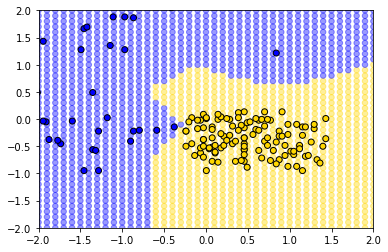

In [24]:
plt.scatter(test_grid['Hemoglobin'], test_grid['Glucose'], 
            color = test_grid['status'].map(colors), alpha=0.4, s=30)


plt.scatter(std_status['Hemoglobin'], std_status['Glucose'], 
            color= std_status['status'].map(colors), edgecolor='k')

plt.xlim(-2, 2)
plt.ylim(-2, 2); 
plt.show()

The decision boundary here is very clear: it snakes round the yellow points from bottom left up to top right.  Where the color changes, our prediction changes for a patient.  As we read from left to right on the $x$-axis, for a given $y$-axis value, the color mostly only changes once: we go blue to yellow, and then we stay yellow (though this is not true around 0.75 on vertical Glucose axes). 
 
### A tougher example

Here is a tougher example: let's use `White Blood Cell Count` instead of Hemoglobin.

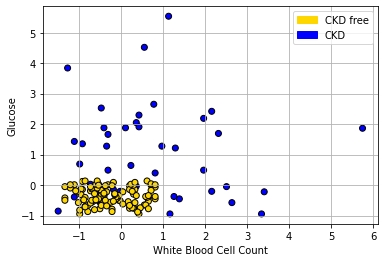

In [25]:
plt.scatter(std_status['White Blood Cell Count'], 
            std_status['Glucose'], color= std_status['status'].map(colors),
            edgecolor='k')

plt.legend(handles=[gold_patch, blue_patch])
plt.xlabel('White Blood Cell Count')
plt.ylabel("Glucose")

plt.grid()
plt.show()

In the bottom left of the plot, we can clearly see some blue dots (CKD) among the yellow ones (CKD free).  To see the issue in starker relief, let's enlarge the "problem" area and place a new patient (in red):  

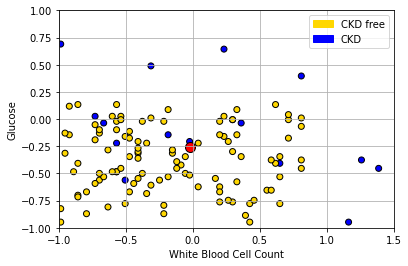

In [26]:
plt.scatter(std_status['White Blood Cell Count'], 
            std_status['Glucose'], color= std_status['status'].map(colors),
            edgecolor='k')

plt.legend(handles=[gold_patch, blue_patch])
plt.xlabel('White Blood Cell Count')
plt.ylabel("Glucose")
plt.xlim(-1,1.5)
plt.ylim(-1,1)


new_patient = np.array([-0.02,-0.26])
plt.scatter(new_patient[0], new_patient[1], s=100, 
            color="red",ec="black")

plt.grid()
plt.show()

The "problem" here is that our new patient (in red) is closest to a blue point, and thus we predict CKD for them.  But they are in a space where, generally speaking, CKD is rare.  So our prediction is "unlucky" in some sense. Our main point is that using only a *single* nearest neighbor may be misleading.   

## k-Nearest Neighbors
To reiterate: the (single) nearest point here was blue (meaning CKD), but that was potentially misleading, because there were many more yellow points (meaning CKD free).  

What we might do instead is look at the **$k$ nearest neighbors**, where $k=3$ or some other *odd* number. We then take a vote of those $k$ nearest neighbors, and whichever is the majority class is our prediction.  This method is called **k Nearest Neighbors** or **kNN**.

Looking back at our problem case, the patient's three nearest neighbors are two CKD-free patients (yellow), and one with CKD (blue). The majority vote is CKD-free, and that becomes our prediction.

Generally speaking we like to use a $k$ that is odd and relatively small.  $k$ must be odd to ensure our votes doesn't lead to ties -- and thus an ambiguous prediction.  And we prefer $k$ to be small to avoid "smoothing" too much.  To see the problem, suppose we picked $k=n$: that is, we just the number of nearest neighbors equal to the size of our data.  This means that every new patient's predicted outcome is just a majority vote of all the current data points. But this will not change, no matter where the new patient is in terms of attributes.  And that does not seem like a helpful classifier.